In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tss24-competition-3/sample_submission.csv
/kaggle/input/tss24-competition-3/train.csv
/kaggle/input/tss24-competition-3/test.csv


## Load the data: Reads the train, test, and sample submission files.

In [29]:
# Load the data
train = pd.read_csv('/kaggle/input/tss24-competition-3/train.csv')
test = pd.read_csv('/kaggle/input/tss24-competition-3/test.csv')
sample_submission = pd.read_csv('/kaggle/input/tss24-competition-3/sample_submission.csv')

# Display the first few rows of the training data
print(train.head())

   id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0   55         165          60       81.0             0.5   
1   1   70         165          65       89.0             0.6   
2   2   20         170          75       81.0             0.4   
3   3   35         180          95      105.0             1.5   
4   4   30         165          60       80.5             1.5   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...  HDL  LDL  \
0              0.6              1               1       135  ...   40   75   
1              0.7              2               2       146  ...   57  126   
2              0.5              1               1       118  ...   45   93   
3              1.2              1               1       131  ...   38  102   
4              1.0              1               1       121  ...   44   93   

   hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  \
0        16.5              1               1.0   22   25   2

## Spliting the Data

In [30]:
# Separate features and target
X = train.drop(columns=['id', 'smoking'])
y = train['smoking']

## Visualising the data

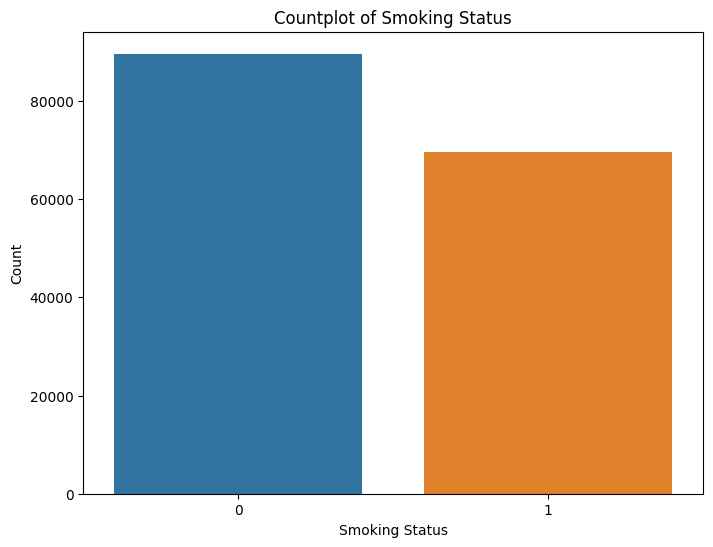

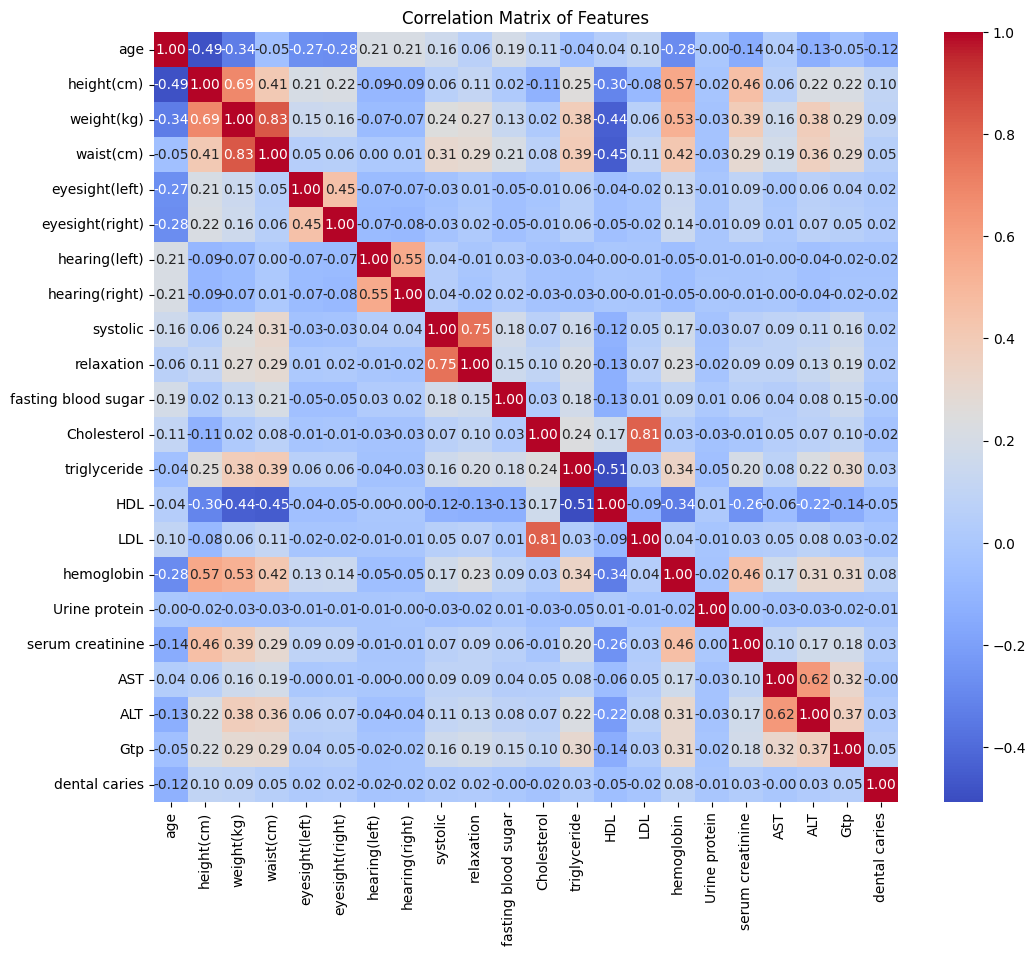

In [31]:
# Load the data
train = pd.read_csv('/kaggle/input/tss24-competition-3/train.csv')

# Countplot for the target variable 'smoking'
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='smoking')
plt.title('Countplot of Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

# Correlation matrix
# Drop the 'id' column as it is not useful for correlation analysis
corr_matrix = train.drop(columns=['id', 'smoking']).corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()


## Preprocess the data:

In [32]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(test.drop(columns=['id']))

In [33]:
# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_scores = []

# Arrays to store the true values and predicted probabilities for the ROC curve
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Create an array to hold test predictions
test_preds = np.zeros(len(test))

In [34]:
# Perform stratified k-fold cross-validation
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Train an XGBoost Classifier
    model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    val_preds = model.predict_proba(X_val)[:, 1]
    val_score = roc_auc_score(y_val, val_preds)
    val_scores.append(val_score)
    
    # Compute ROC curve and area under the curve
    fpr, tpr, _ = roc_curve(y_val, val_preds)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = roc_auc_score(y_val, val_preds)
    aucs.append(roc_auc)

    # Make predictions on the test set and accumulate them
    test_preds += model.predict_proba(X_test)[:, 1] / kf.n_splits

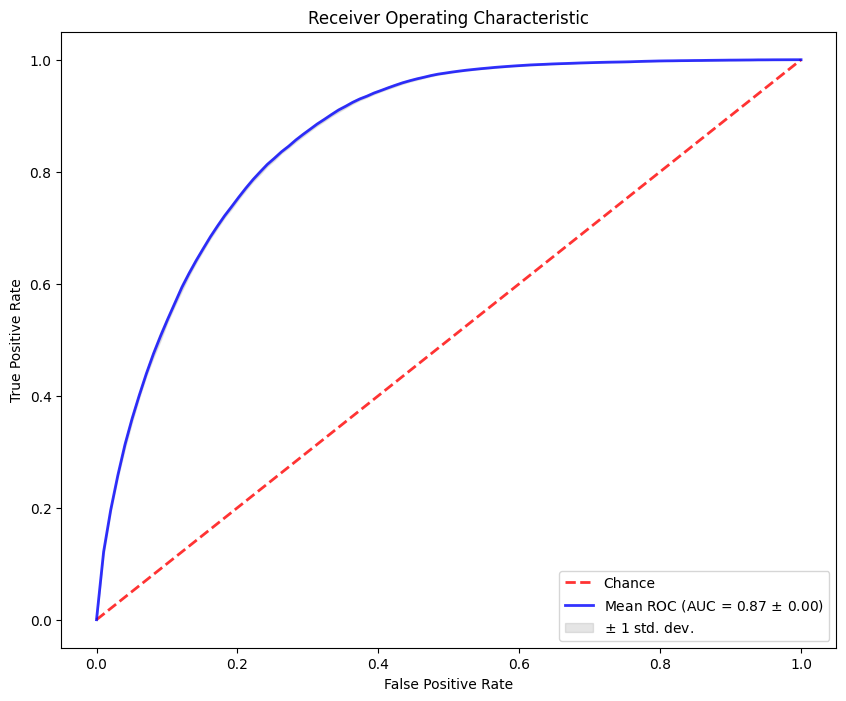

In [35]:
# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [36]:
# Print the average validation ROC AUC score
print(f'Average Validation ROC AUC: {np.mean(val_scores)}')

Average Validation ROC AUC: 0.8651536244144789


## Prepare the submission file:

In [37]:
# Prepare the submission file
submission = sample_submission.copy()
submission['smoking'] = test_preds

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!
